In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same', kernel_initializer='he_uniform', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same', kernel_initializer='he_uniform')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, 
                          padding='same', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, 
                          padding='same', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4348 - acc: 0.4002
Epoch 00001: val_loss improved from inf to 2.08632, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_3_conv_checkpoint/001-2.0863.hdf5
36805/36805 [==============================] - 143s 4ms/sample - loss: 2.4348 - acc: 0.4002 - val_loss: 2.0863 - val_acc: 0.4785
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0905 - acc: 0.6925
Epoch 00002: val_loss improved from 2.08632 to 1.92642, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_3_conv_checkpoint/002-1.9264.hdf5
36805/36805 [==============================] - 137s 4ms/sample - loss: 1.0904 - acc: 0.6925 - val_loss: 1.9264 - val_acc: 0.5374
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5026 - acc: 0.8572
Epoch 00003: val_loss improved from 1

36800/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9911
Epoch 00028: val_loss did not improve from 1.91085
36805/36805 [==============================] - 137s 4ms/sample - loss: 0.0453 - acc: 0.9910 - val_loss: 3.3916 - val_acc: 0.5507
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9868
Epoch 00029: val_loss did not improve from 1.91085
36805/36805 [==============================] - 137s 4ms/sample - loss: 0.0612 - acc: 0.9868 - val_loss: 3.4133 - val_acc: 0.5514
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9866
Epoch 00030: val_loss did not improve from 1.91085
36805/36805 [==============================] - 136s 4ms/sample - loss: 0.0630 - acc: 0.9866 - val_loss: 3.5493 - val_acc: 0.5439
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0613 - acc: 0.9861
Epoch 00031: val_loss did not improve from 1.91085
36805/36805 [=====================

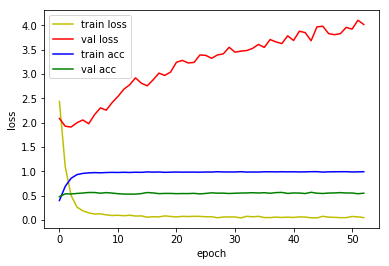

4815/4815 [==============================] - 8s 2ms/sample - loss: 2.0421 - acc: 0.5047
Loss: 2.0421048491914697 Accuracy: 0.5046729

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0005 - acc: 0.4248
Epoch 00001: val_loss improved from inf to 1.51890, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_4_conv_checkpoint/001-1.5189.hdf5
36805/36805 [==============================] - 149s 4ms/sample - loss: 2.0004 - acc: 0.4248 - val_loss: 1.5189 - val_acc: 0.5698
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2093 - acc: 0.6410
Epoch 00002: val_loss improved from 1.51890 to 1.30884, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_4_conv_checkpoint/002-1.3088.hdf5
36805/36805 [==============================] - 143s 4ms/sample - loss: 1.2096 - acc: 0.6409 - val_loss: 1.3088 - val_acc: 0.6287
Epoch 3/500
36800/36805 [======================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9887
Epoch 00028: val_loss did not improve from 1.19175
36805/36805 [==============================] - 143s 4ms/sample - loss: 0.0478 - acc: 0.9886 - val_loss: 1.6828 - val_acc: 0.6837
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9916
Epoch 00029: val_loss did not improve from 1.19175
36805/36805 [==============================] - 142s 4ms/sample - loss: 0.0386 - acc: 0.9915 - val_loss: 1.6762 - val_acc: 0.6841
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9906
Epoch 00030: val_loss did not improve from 1.19175
36805/36805 [==============================] - 143s 4ms/sample - loss: 0.0401 - acc: 0.9906 - val_loss: 1.7034 - val_acc: 0.6790
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9915
Epoch 00031: val_loss did not improve from 1.19175
36805/36805 [========


1D_CNN_custom_conv_3_VGG_he-uniform_BN_4_conv Model


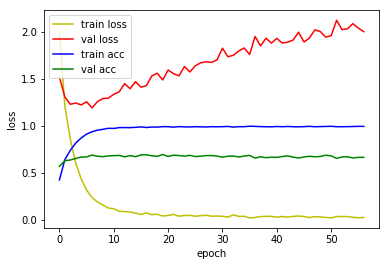

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.3333 - acc: 0.6442 1s - loss: 1.3
Loss: 1.333261698552505 Accuracy: 0.64423674

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9095 - acc: 0.4346
Epoch 00001: val_loss improved from inf to 1.36379, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_5_conv_checkpoint/001-1.3638.hdf5
36805/36805 [==============================] - 159s 4ms/sample - loss: 1.9095 - acc: 0.4346 - val_loss: 1.3638 - val_acc: 0.5966
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2052 - acc: 0.6367
Epoch 00002: val_loss improved from 1.36379 to 1.16764, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_5_conv_checkpoint/002-1.1676.hdf5
36805/36805 [==============================] - 150s 4ms/sample - loss: 1.2052 - acc: 0.6367 - val_loss: 1.1676 - val_acc: 0.6518
Epoch 3/500
36800/36805 [=======

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9837
Epoch 00028: val_loss did not improve from 0.97340
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.0629 - acc: 0.9837 - val_loss: 1.2142 - val_acc: 0.7447
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9926
Epoch 00029: val_loss did not improve from 0.97340
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.0391 - acc: 0.9925 - val_loss: 1.1638 - val_acc: 0.7538
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9866
Epoch 00030: val_loss did not improve from 0.97340
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.0542 - acc: 0.9866 - val_loss: 1.3112 - val_acc: 0.7428
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9917
Epoch 00031: val_loss did not improve from 0.97340
36805/36805 [========

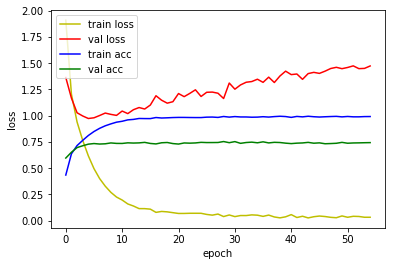

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.0375 - acc: 0.6947
Loss: 1.0374559034563422 Accuracy: 0.69470406

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9402 - acc: 0.4085
Epoch 00001: val_loss improved from inf to 1.32773, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_6_conv_checkpoint/001-1.3277.hdf5
36805/36805 [==============================] - 164s 4ms/sample - loss: 1.9402 - acc: 0.4085 - val_loss: 1.3277 - val_acc: 0.5919
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2529 - acc: 0.6231
Epoch 00002: val_loss improved from 1.32773 to 1.08502, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_6_conv_checkpoint/002-1.0850.hdf5
36805/36805 [==============================] - 153s 4ms/sample - loss: 1.2529 - acc: 0.6231 - val_loss: 1.0850 - val_acc: 0.6774
Epoch 3/500
36800/36805 [=====================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1249 - acc: 0.9665
Epoch 00024: val_loss did not improve from 0.54898
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.1250 - acc: 0.9665 - val_loss: 0.5522 - val_acc: 0.8581
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9627
Epoch 00025: val_loss did not improve from 0.54898
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.1297 - acc: 0.9626 - val_loss: 0.5787 - val_acc: 0.8556
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1212 - acc: 0.9663
Epoch 00026: val_loss did not improve from 0.54898
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.1216 - acc: 0.9662 - val_loss: 0.5631 - val_acc: 0.8551
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1058 - acc: 0.9723
Epoch 00027: val_loss did not improve from 0.54898
36805/36805 [========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9890
Epoch 00054: val_loss did not improve from 0.54898
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0450 - acc: 0.9890 - val_loss: 0.6093 - val_acc: 0.8658
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9929
Epoch 00055: val_loss did not improve from 0.54898
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0320 - acc: 0.9929 - val_loss: 0.5943 - val_acc: 0.8703
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9851
Epoch 00056: val_loss did not improve from 0.54898
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0557 - acc: 0.9851 - val_loss: 0.6443 - val_acc: 0.8651
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9927
Epoch 00057: val_loss did not improve from 0.54898
36805/36805 [========

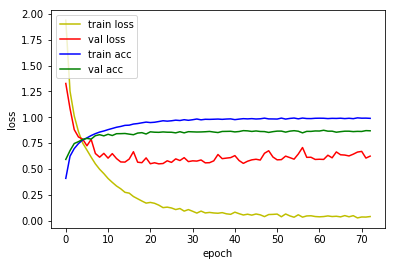

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.6110 - acc: 0.8368
Loss: 0.6109846885825738 Accuracy: 0.8367601

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1114 - acc: 0.3599
Epoch 00001: val_loss improved from inf to 1.38866, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_7_conv_checkpoint/001-1.3887.hdf5
36805/36805 [==============================] - 171s 5ms/sample - loss: 2.1115 - acc: 0.3599 - val_loss: 1.3887 - val_acc: 0.5865
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2814 - acc: 0.6145
Epoch 00002: val_loss improved from 1.38866 to 0.98260, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_7_conv_checkpoint/002-0.9826.hdf5
36805/36805 [==============================] - 157s 4ms/sample - loss: 1.2813 - acc: 0.6145 - val_loss: 0.9826 - val_acc: 0.7121
Epoch 3/500
36800/36805 [=====================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1180 - acc: 0.9663
Epoch 00024: val_loss did not improve from 0.25392
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.1181 - acc: 0.9663 - val_loss: 0.2595 - val_acc: 0.9250
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1189 - acc: 0.9651
Epoch 00025: val_loss did not improve from 0.25392
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.1190 - acc: 0.9651 - val_loss: 0.2778 - val_acc: 0.9243
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1057 - acc: 0.9688
Epoch 00026: val_loss improved from 0.25392 to 0.25069, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_7_conv_checkpoint/026-0.2507.hdf5
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.1059 - acc: 0.9688 - val_loss: 0.2507 - val_acc: 0.9294
Epoch 27/500
36800/36805 [============================>.] 

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9860
Epoch 00052: val_loss did not improve from 0.23540
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0496 - acc: 0.9860 - val_loss: 0.2680 - val_acc: 0.9324
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9896
Epoch 00053: val_loss did not improve from 0.23540
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0379 - acc: 0.9896 - val_loss: 0.2557 - val_acc: 0.9357
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9911
Epoch 00054: val_loss did not improve from 0.23540
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0340 - acc: 0.9910 - val_loss: 0.2618 - val_acc: 0.9383
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9874
Epoch 00055: val_loss did not improve from 0.23540
36805/36805 [========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9936
Epoch 00082: val_loss did not improve from 0.23540
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0232 - acc: 0.9936 - val_loss: 0.2753 - val_acc: 0.9359
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9935
Epoch 00083: val_loss did not improve from 0.23540
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0236 - acc: 0.9935 - val_loss: 0.2561 - val_acc: 0.9406
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9947
Epoch 00084: val_loss did not improve from 0.23540
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0216 - acc: 0.9947 - val_loss: 0.2755 - val_acc: 0.9390
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9939
Epoch 00085: val_loss did not improve from 0.23540
36805/36805 [========

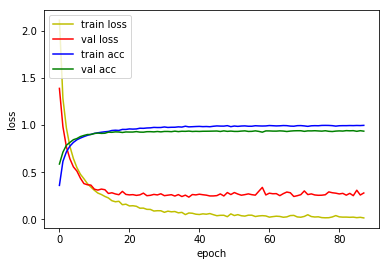

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.3086 - acc: 0.9178
Loss: 0.30864812238596434 Accuracy: 0.91775703

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1736 - acc: 0.3390
Epoch 00001: val_loss improved from inf to 1.46105, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_8_conv_checkpoint/001-1.4610.hdf5
36805/36805 [==============================] - 175s 5ms/sample - loss: 2.1736 - acc: 0.3390 - val_loss: 1.4610 - val_acc: 0.5579
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2069 - acc: 0.6347
Epoch 00002: val_loss improved from 1.46105 to 0.85685, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_8_conv_checkpoint/002-0.8569.hdf5
36805/36805 [==============================] - 157s 4ms/sample - loss: 1.2071 - acc: 0.6346 - val_loss: 0.8569 - val_acc: 0.7536
Epoch 3/500
36800/36805 [===================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9709
Epoch 00024: val_loss improved from 0.18011 to 0.16513, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_8_conv_checkpoint/024-0.1651.hdf5
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0974 - acc: 0.9709 - val_loss: 0.1651 - val_acc: 0.9546
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0770 - acc: 0.9781
Epoch 00025: val_loss did not improve from 0.16513
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0770 - acc: 0.9781 - val_loss: 0.1740 - val_acc: 0.9511
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0796 - acc: 0.9766
Epoch 00026: val_loss did not improve from 0.16513
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0799 - acc: 0.9766 - val_loss: 0.1779 - val_acc: 0.9485
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9941
Epoch 00052: val_loss did not improve from 0.16437
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0234 - acc: 0.9941 - val_loss: 0.1758 - val_acc: 0.9574
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9954
Epoch 00053: val_loss did not improve from 0.16437
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0178 - acc: 0.9954 - val_loss: 0.2087 - val_acc: 0.9522
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9942
Epoch 00054: val_loss did not improve from 0.16437
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0235 - acc: 0.9942 - val_loss: 0.1909 - val_acc: 0.9548
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9935
Epoch 00055: val_loss did not improve from 0.16437
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9923
Epoch 00081: val_loss did not improve from 0.15979
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0264 - acc: 0.9922 - val_loss: 0.1817 - val_acc: 0.9569
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9931
Epoch 00082: val_loss did not improve from 0.15979
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0246 - acc: 0.9931 - val_loss: 0.1856 - val_acc: 0.9592
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9974
Epoch 00083: val_loss did not improve from 0.15979
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0106 - acc: 0.9974 - val_loss: 0.1821 - val_acc: 0.9569
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9977
Epoch 00084: val_loss did not improve from 0.15979
36805/36805 [=====================

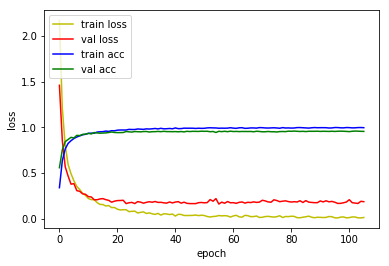

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2257 - acc: 0.9398
Loss: 0.22574864176188056 Accuracy: 0.93977153

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7060 - acc: 0.4686
Epoch 00001: val_loss improved from inf to 0.83909, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_9_conv_checkpoint/001-0.8391.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 1.7060 - acc: 0.4686 - val_loss: 0.8391 - val_acc: 0.7370
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7354 - acc: 0.7702
Epoch 00002: val_loss improved from 0.83909 to 0.51322, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_BN_9_conv_checkpoint/002-0.5132.hdf5
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.7356 - acc: 0.7701 - val_loss: 0.5132 - val_acc: 0.8418
Epoch 3/500
36800/36805 [===================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9865
Epoch 00024: val_loss did not improve from 0.16459
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.0463 - acc: 0.9865 - val_loss: 0.1825 - val_acc: 0.9522
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9854
Epoch 00025: val_loss did not improve from 0.16459
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.0504 - acc: 0.9854 - val_loss: 0.1871 - val_acc: 0.9499
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9875
Epoch 00026: val_loss did not improve from 0.16459
36805/36805 [==============================] - 159s 4ms/sample - loss: 0.0424 - acc: 0.9874 - val_loss: 0.1940 - val_acc: 0.9509
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9882
Epoch 00027: val_loss did not improve from 0.16459
36805/36805 [========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9974
Epoch 00054: val_loss did not improve from 0.16459
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.0103 - acc: 0.9974 - val_loss: 0.1762 - val_acc: 0.9592
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9912
Epoch 00055: val_loss did not improve from 0.16459
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.0278 - acc: 0.9911 - val_loss: 0.1752 - val_acc: 0.9588
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9921
Epoch 00056: val_loss did not improve from 0.16459
36805/36805 [==============================] - 159s 4ms/sample - loss: 0.0255 - acc: 0.9921 - val_loss: 0.1728 - val_acc: 0.9590
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9960
Epoch 00057: val_loss did not improve from 0.16459
36805/36805 [========

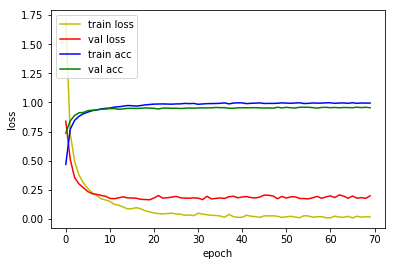

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2108 - acc: 0.9387
Loss: 0.2108305070166276 Accuracy: 0.9387331



In [10]:
base = '1D_CNN_custom_conv_3_VGG_he-uniform_BN'

for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_he-uniform_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_he-uniform_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           2338128     lambda[0][0]                     
                                                        

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.3086 - acc: 0.9178
Loss: 0.30864812238596434 Accuracy: 0.91775703

1D_CNN_custom_conv_3_VGG_he-uniform_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_140_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_140_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_140_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Sequ

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_he-uniform_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           2338128     lambda[0][0]                     
                                                        

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.3292 - acc: 0.9196
Loss: 0.3291866436121001 Accuracy: 0.9196262

1D_CNN_custom_conv_3_VGG_he-uniform_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_140_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_140_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_140_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Sequen